# Imports

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans

import keras_tuner as kt
from sklearn.ensemble import StackingClassifier
import tensorflow as tf
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as prepoc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel 

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from scipy.stats import randint, uniform, reciprocal, expon

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# for building and training neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Reading the data

In [2]:
train_data = pd.read_csv('C:\\Users\\fabio\\Downloads\\Final Spaceship\\Final Spaceship\\Final Spaceship\\train.csv')
test_data = pd.read_csv('C:\\Users\\fabio\\Downloads\\Final Spaceship\\Final Spaceship\\Final Spaceship\\test.csv')

# Data processing

### Tweaking

In [3]:
# The name of the passengers isn't going to be used for nothing in this notebook
test_data.drop('Name',inplace=True,axis=1)
train_data.drop('Name', axis=1, inplace=True)

# The passenger group was utilized in processing steps so I already added it here to the DataFrame
test_data['passenger_group']=test_data['PassengerId'].apply(lambda x: x[0:4])
train_data['passenger_group']=train_data['PassengerId'].apply(lambda x: x[0:4])

# The passenger IDs will be used at the end to return the correct IDs with the model previsions
test_passenger_id = test_data['PassengerId']
passenger_id = train_data['PassengerId']

In [4]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,passenger_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,9276
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,9278
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,9279
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,9280


### Classes and functions

In [5]:
binary_columns = ['CryoSleep','VIP']
numeric_columns = ['FoodCourt','RoomService','Spa','VRDeck','ShoppingMall']

cabin_ix = 3 # The cabin index is used in the CabinSeparator class

class CabinSeparator(BaseEstimator, TransformerMixin):
    
    # The Cabin info has the aggregated information of the cabin deck, side and number. This function stores all the information but just returns to the original
    # dataframe the cabin deck and side, given that the number can go until past 1000 and would probably overfit the data and not help very much
    def __init__(self, add_separate_cabin=True):
        self.add_separate_cabin = add_separate_cabin
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.add_separate_cabin:
            X = pd.DataFrame(X)
            cabin_deck = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0])
            cabin_num = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0] if len(str(s).split('/'))==1 else str(s).split('/')[1])
            cabin_side = X.iloc[:, cabin_ix].apply(lambda s: str(s).split('/')[0] if len(str(s).split('/'))==1 else str(s).split('/')[2])
            X['cabin_deck'] = cabin_deck
            X['cabin_side'] = cabin_side
            X = X.drop(X.columns[[cabin_ix]], axis=1)
            return X.values 
        else:
            return X
    def get_feature_names_out(self):
        return ['cabin_deck','cabin_num','cabin_side']
    
    
class FillBinaryNumericTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # I am assuming here that if there is no record of the person in CryoSleep or if they are on the VIP list they probably aren't in neither
        X.loc[:, binary_columns] = X[binary_columns].fillna(False)
        # The same logic applies here, if there is no record of the passenger spending money, they probably didn't spend it
        X.loc[:, numeric_columns] = X[numeric_columns].fillna(0)
        return X

class FillCabinDestHomeAgeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Here the function groups the data by the passanger group, and fills in the other data based on the info of another passanger that's in their group
        # For example if the daughter didn't put her data correct but her mother did, the code will retrieve that information
        X['Cabin'] = X.groupby('passenger_group')['Cabin'].transform(lambda x: x.fillna(x.iloc[0]))
        X['Destination'] = X.groupby('passenger_group')['Destination'].transform(lambda x: x.fillna(x.iloc[0]))
        X['HomePlanet'] = X.groupby('passenger_group')['HomePlanet'].transform(lambda x: x.fillna(x.iloc[0]))
        X['Age'] = X.groupby('passenger_group')['Age'].transform(lambda value: value.fillna(value.mean()))
        return X

class FillRestTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # For the groups that didn't have any information, I just decided to fill in the Age with the mean of values from that group and the other just a 'None' string
        X['Age'] = X.groupby('passenger_group')['Age'].transform(lambda value: value.fillna(value.mean()))
        X['Age'] = X['Age'].transform(lambda value: value.fillna(value.mean()))
        X[['Cabin','HomePlanet','Destination']] = X[['Cabin','HomePlanet','Destination']].fillna('None')
        return X

class AddTotalSpent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        total_spent = np.sum(X[:, 5:10], axis=1)
        X = np.column_stack((X, total_spent))
        return X
    
class AddPolyFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=3, addpoly=True):
        self.degree = degree
        self.addpoly = addpoly
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)
    
    def fit(self, X, y=None):
        if self.addpoly:
            self.poly.fit(X)
        return self
    
    def transform(self, X):
        if self.addpoly:
            return self.poly.transform(X)
        else:
            return X


### Applying functions and classes

In [6]:
train_column_names = [col for col in train_data.columns if col != 'Cabin'] + ['cabin_deck','cabin_side','total_spent']
test_column_names = [col for col in test_data.columns if col != 'Cabin'] + ['cabin_deck','cabin_side','total_spent']

In [7]:
preprocessing = Pipeline([
    ('binary_numeric', FillBinaryNumericTransformer()),
    ('cabin_dest_home_age', FillCabinDestHomeAgeTransformer()),
    ('rest', FillRestTransformer()),
    ('cabin_separator', CabinSeparator()),
    ('add_total_spent', AddTotalSpent()),
])

treated_train_data = pd.DataFrame(preprocessing.fit_transform(train_data), columns=train_column_names)
treated_test_data = pd.DataFrame(preprocessing.transform(test_data), columns=test_column_names)

C:\Users\fabio\AppData\Local\Temp\ipykernel_7104\2438825852.py:36: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, binary_columns] = X[binary_columns].fillna(False)
C:\Users\fabio\AppData\Local\Temp\ipykernel_7104\2438825852.py:36: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, binary_columns] = X[binary_columns].fillna(False)


In [8]:
columns_to_convert = ['total_spent', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Convert columns to numeric type
treated_train_data[columns_to_convert] = treated_train_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
treated_test_data[columns_to_convert] = treated_test_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

treated_train_data[['VIP','CryoSleep']] = treated_train_data[['VIP','CryoSleep']].astype(int)
treated_test_data[['VIP','CryoSleep']] = treated_test_data[['VIP','CryoSleep']].astype(int)

PolynomialFeatures:
After running a RandomizedSearch on XGBoost, SVClassifier and Linear Regression with Polynomial Features optional. XGBoost running better without it, SVClassifier showing 0% improvement, even though the best result had it turned on and Linear Regression showing almost 0% improvement as well, I decided not using it.

XGBoost: {'preprocessing__addpoly__addpoly': False, 'xgb__colsample_bytree': 0.7957804003872713, 'xgb__learning_rate': 0.02404948764126008, 'xgb__max_depth': 6, 'xgb__min_child_weight': 7, 'xgb__n_estimators': 478, 'xgb__subsample': 0.9862040950913502}

LRegression: {'lr__C': 1.2853196278359436, 'lr__max_iter': 1253, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'preprocessing__addpoly__addpoly': True} -> This had the same score as without it

In [9]:
poly_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spent']

# Separate the DataFrame into two parts
poly_data = treated_train_data[poly_columns]
other_data = treated_train_data.drop(columns=poly_columns)

# Initialize PolynomialFeatures for degree 3
poly = PolynomialFeatures(degree=3, include_bias=False)

# Fit and transform the data
poly_data_transformed = poly.fit_transform(poly_data)

# Get the new feature names
poly_feature_names = poly.get_feature_names_out(input_features=poly_columns)

# Create a new DataFrame with the transformed polynomial features
poly_data_transformed_df = pd.DataFrame(poly_data_transformed, columns=poly_feature_names)

# Combine the transformed columns with the untouched columns
final_treated_train_data = pd.concat([poly_data_transformed_df, other_data.reset_index(drop=True)], axis=1)

final_treated_train_data.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent,Age^2,Age RoomService,Age FoodCourt,...,total_spent^3,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Transported,passenger_group,cabin_deck,cabin_side
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1521.0,0.0,0.0,...,0.000000e+00,0001_01,Europa,0,TRAPPIST-1e,0,False,0001,B,P
1,24.0,109.0,9.0,25.0,549.0,44.0,692.0,576.0,2616.0,216.0,...,3.313739e+08,0002_01,Earth,0,TRAPPIST-1e,0,True,0002,F,S
2,58.0,43.0,3576.0,0.0,6715.0,49.0,10335.0,3364.0,2494.0,207408.0,...,1.103904e+12,0003_01,Europa,0,TRAPPIST-1e,1,False,0003,A,S
3,33.0,0.0,1283.0,371.0,3329.0,193.0,4983.0,1089.0,0.0,42339.0,...,1.237293e+11,0003_02,Europa,0,TRAPPIST-1e,0,False,0003,A,S
4,16.0,303.0,70.0,151.0,565.0,2.0,1089.0,256.0,4848.0,1120.0,...,1.291468e+09,0004_01,Earth,0,TRAPPIST-1e,0,True,0004,F,S


In [10]:
treated_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      8693 non-null   object 
 1   HomePlanet       8693 non-null   object 
 2   CryoSleep        8693 non-null   int32  
 3   Destination      8693 non-null   object 
 4   Age              8693 non-null   float64
 5   VIP              8693 non-null   int32  
 6   RoomService      8693 non-null   float64
 7   FoodCourt        8693 non-null   float64
 8   ShoppingMall     8693 non-null   float64
 9   Spa              8693 non-null   float64
 10  VRDeck           8693 non-null   float64
 11  Transported      8693 non-null   object 
 12  passenger_group  8693 non-null   object 
 13  cabin_deck       8693 non-null   object 
 14  cabin_side       8693 non-null   object 
 15  total_spent      8693 non-null   float64
dtypes: float64(7), int32(2), object(7)
memory usage: 1018.8+ KB


In [11]:
print(f'A quantia de valores vazios no conjunto de treino é: {treated_train_data.isnull().sum().sum()}')
print(f'A quantia de valores vazios no conjunto de teste é: {treated_test_data.isnull().sum().sum()}')

A quantia de valores vazios no conjunto de treino é: 0
A quantia de valores vazios no conjunto de teste é: 0


# EDA

### Outliers

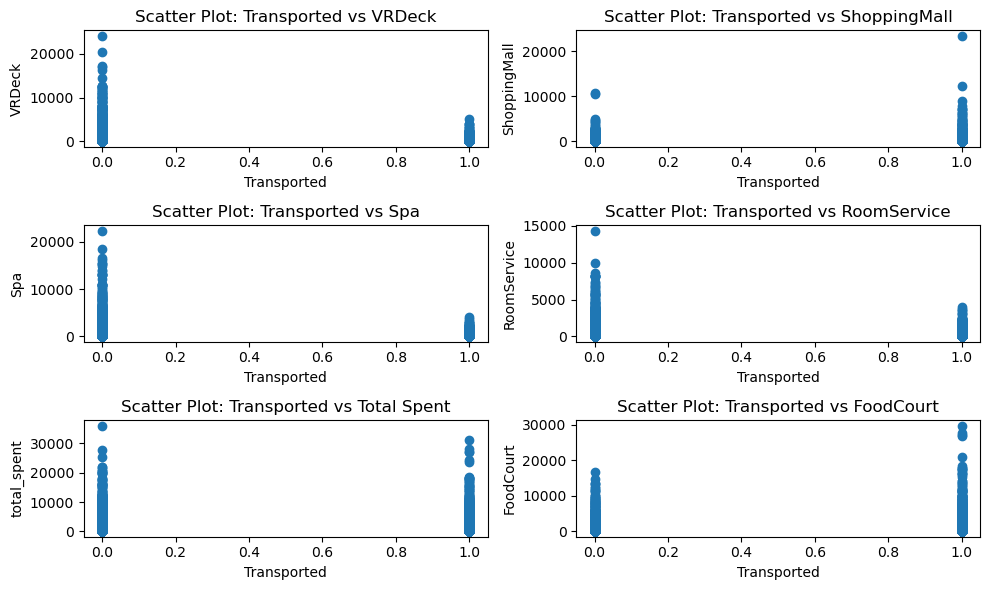

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6))  # Create a figure and a 1x2 subplot

# Plot on the first subplot
axs[0][0].scatter(treated_train_data['Transported'], treated_train_data['VRDeck'])
axs[0][0].set_xlabel('Transported')
axs[0][0].set_ylabel('VRDeck')
axs[0][0].set_title('Scatter Plot: Transported vs VRDeck')

# Plot on the second subplot
axs[0][1].scatter(treated_train_data['Transported'], treated_train_data['ShoppingMall'])
axs[0][1].set_xlabel('Transported')
axs[0][1].set_ylabel('ShoppingMall')
axs[0][1].set_title('Scatter Plot: Transported vs ShoppingMall')

# Plot on the second subplot
axs[1][0].scatter(treated_train_data['Transported'], treated_train_data['Spa'])
axs[1][0].set_xlabel('Transported')
axs[1][0].set_ylabel('Spa')
axs[1][0].set_title('Scatter Plot: Transported vs Spa')

# Plot on the second subplot
axs[1][1].scatter(treated_train_data['Transported'], treated_train_data['RoomService'])
axs[1][1].set_xlabel('Transported')
axs[1][1].set_ylabel('RoomService')
axs[1][1].set_title('Scatter Plot: Transported vs RoomService')

# Plot on the second subplot
axs[2][0].scatter(treated_train_data['Transported'], treated_train_data['total_spent'])
axs[2][0].set_xlabel('Transported')
axs[2][0].set_ylabel('total_spent')
axs[2][0].set_title('Scatter Plot: Transported vs Total Spent')

# Plot on the second subplot
axs[2][1].scatter(treated_train_data['Transported'], treated_train_data['FoodCourt'])
axs[2][1].set_xlabel('Transported')
axs[2][1].set_ylabel('FoodCourt')
axs[2][1].set_title('Scatter Plot: Transported vs FoodCourt')

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()

In [13]:
drop_ix_food = treated_train_data[(treated_train_data['FoodCourt']>20000)].index
drop_ix_shopping = treated_train_data[(treated_train_data['ShoppingMall']>10000)].index

treated_train_data = treated_train_data.drop(drop_ix_food)
treated_train_data = treated_train_data.drop(drop_ix_shopping)

### Checking relationships between features

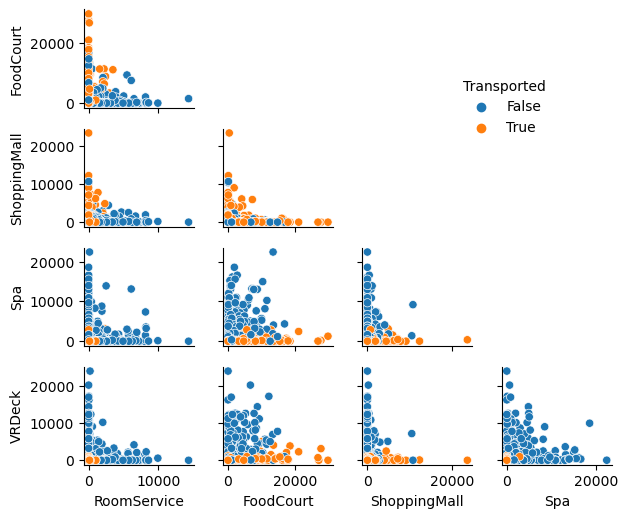

In [14]:
numerical_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

figsize = (1.5, 1.3)
g = sns.PairGrid(train_data, hue='Transported', vars=numerical_columns, height=figsize[1], aspect=figsize[0]/figsize[1])
g.map_lower(sns.scatterplot)
legend = g.add_legend(loc='upper right', bbox_to_anchor=(0.65, 0.7))

for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

plt.show()

In [15]:
y_train = treated_train_data['Transported'].astype(int)
treated_train_data.drop('Transported', axis=1, inplace=True)
treated_train_data.drop('PassengerId', axis=1, inplace=True)
treated_train_data.drop('passenger_group', axis=1, inplace=True)

### Feature Distribution

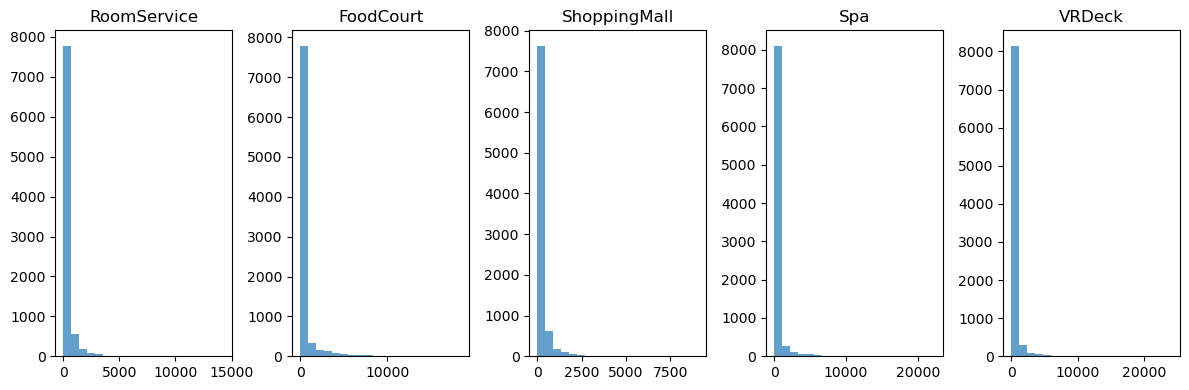

In [16]:
# Plot histograms for each variable
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(12, 4))

for i, var in enumerate(numerical_columns):
    axes[i].hist(treated_train_data[var], bins=20, alpha=0.7)
    axes[i].set_title(var)

plt.tight_layout()
plt.show()

In [17]:
from sklearn.preprocessing import PowerTransformer

normalizer_pipeline = Pipeline([
    ('feature_processing', ColumnTransformer([
        ('normalizer', PowerTransformer(method='yeo-johnson'), make_column_selector(dtype_include=float)),
        ('encoder', OneHotEncoder(), make_column_selector(dtype_exclude=np.number))
    ], remainder='passthrough')),
])

treated_train_data = pd.DataFrame(normalizer_pipeline.fit_transform(treated_train_data), 
                                  columns= [col.replace('normalizer__', '').replace('remainder__', '').replace('encoder__', '') for col in normalizer_pipeline.named_steps['feature_processing'].get_feature_names_out()])

treated_test_data = pd.DataFrame(normalizer_pipeline.transform(treated_test_data), 
                                 columns= [col.replace('normalizer__', '').replace('remainder__', '').replace('encoder__', '') for col in normalizer_pipeline.named_steps['feature_processing'].get_feature_names_out()])

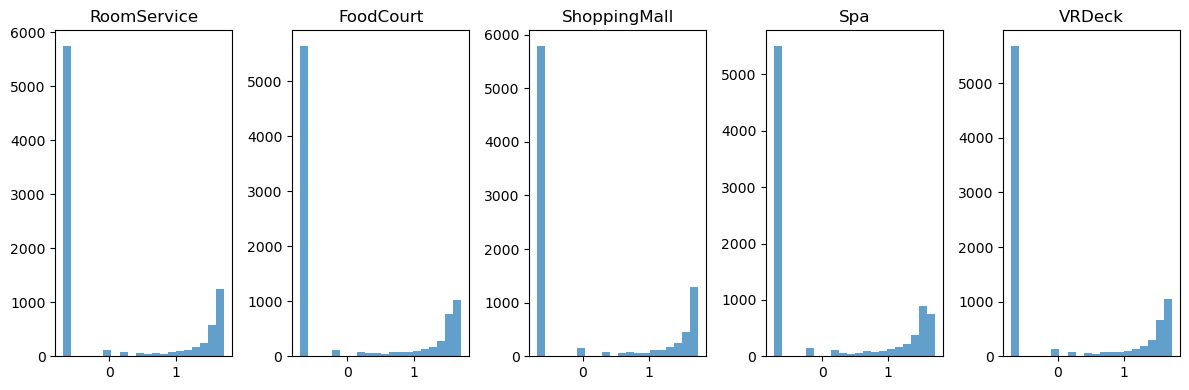

In [18]:
# Plot histograms for each variable
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(12, 4))

for i, var in enumerate(numerical_columns):
    axes[i].hist(treated_train_data[var], bins=20, alpha=0.7)
    axes[i].set_title(var)

plt.tight_layout()
plt.show()

# Model

In [19]:
treated_train_data.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_None,cabin_deck_T,cabin_side_None,cabin_side_P,cabin_side_S,CryoSleep,VIP
0,0.731887,-0.689689,-0.706186,-0.681240,-0.725642,-0.698948,-1.105262,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.264127,1.452192,0.773579,1.276303,1.560188,1.293138,0.693685,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.864957,1.301818,1.656622,-0.681240,1.682772,1.314024,1.556794,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.347326,-0.689689,1.609710,1.633968,1.659822,1.512007,1.316265,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.856918,1.560482,1.304436,1.560942,1.562410,0.239261,0.833071,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
X_train, X_val, y_train, y_val = train_test_split(treated_train_data, y_train, train_size = 0.8)

In [ ]:
X_train.describe()

### Gradient Classifier

In [ ]:
gbc_pipeline = Pipeline([
    ('gbc', GradientBoostingClassifier()), # Classifier step
])

gbc_pipeline.fit(X_train, y_train)

gbc_accuracy = cross_val_score(gbc_pipeline, X_val, y_val,
                              scoring='accuracy', cv=10)

pd.Series(gbc_accuracy).describe()

In [ ]:
param_distribs_gbc = {
    'gbc__n_estimators': randint(100, 500), 
    'gbc__learning_rate': uniform(0.01, 0.3), 
    'gbc__subsample': uniform(0.5, 0.49), 
    'gbc__max_depth': randint(3, 15),
    'gbc__min_samples_split': randint(2, 20),
    'gbc__min_samples_leaf': randint(1, 10),
    'gbc__max_features': uniform(0.5, 0.49)
}

# Assuming gbc_pipeline is your pipeline with GradientBoostingClassifier
rnd_search_gbc = RandomizedSearchCV(gbc_pipeline, param_distribs_gbc, n_iter=200, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

In [ ]:
rnd_search_gbc.fit(X_train, y_train)

In [ ]:
print(rnd_search_xgb.best_params_)

print(rnd_search_xgb.best_score_)

final_xgb = rnd_search_xgb.best_estimator_

### XGBoost

poly_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spent']

preprocessor = ColumnTransformer(
    transformers=[
        ('addpoly', AddPolyFeatures(degree=3, addpoly=True), poly_columns),
    ], remainder='passthrough'
)

In [52]:
xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier(enable_categorical=True, n_jobs=-1)), # Classifier step
])

xgb_pipeline.fit(X_train, y_train)

xgb_accuracy = cross_val_score(xgb_pipeline, X_val, y_val,
                              scoring='accuracy', cv=10)

pd.Series(xgb_accuracy).describe()

count    10.000000
mean      0.789276
std       0.027954
min       0.751445
25%       0.768363
50%       0.781609
75%       0.808086
max       0.844828
dtype: float64

In [53]:
param_distribs_xgb = {
    'xgb__n_estimators': randint(100, 500), 
    'xgb__learning_rate': uniform(0.01, 0.3), 
    'xgb__subsample': uniform(0.5, 0.49), 
    'xgb__max_depth': randint(3, 15),
    'xgb__colsample_bytree': uniform(0.5, 0.49),  
    'xgb__min_child_weight': randint(1, 10),
}

rnd_search_xgb = RandomizedSearchCV(xgb_pipeline, param_distribs_xgb, n_iter=200, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

In [83]:
y_train

2210    0
4947    0
8566    1
8038    0
4714    0
       ..
7681    1
6173    0
3732    1
1858    0
2460    0
Name: Transported, Length: 6947, dtype: int32

In [54]:
rnd_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=True,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interaction_constrai...
                                        'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023995637910>,
                                        'xgb__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000239995F7710>,
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002399B69B390>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023918086550>},
                   scoring='accuracy', verbose=1)

In [55]:
print(rnd_search_xgb.best_params_)

print(rnd_search_xgb.best_score_)

final_xgb = rnd_search_xgb.best_estimator_

{'xgb__colsample_bytree': 0.6283708814993149, 'xgb__learning_rate': 0.03167309748977578, 'xgb__max_depth': 6, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 126, 'xgb__subsample': 0.6230673069280024}
0.8006335244475778


In [56]:
feature_importances = final_xgb['xgb'].feature_importances_

important_features = sorted(zip(feature_importances,
         X_train.columns),
         reverse=True)

features = []

for feature in important_features[0:20]:
    features.append(feature[1])

In [57]:
features

['CryoSleep',
 'total_spent',
 'HomePlanet_Earth',
 'cabin_deck_G',
 'FoodCourt',
 'cabin_deck_E',
 'VRDeck',
 'Spa',
 'RoomService',
 'HomePlanet_Europa',
 'ShoppingMall',
 'RoomService/total_spent',
 'Spa/total_spent',
 'cabin_deck_F',
 'HomePlanet_Mars',
 'cabin_deck_C',
 '1/Spa',
 'VRDeck/total_spent',
 '1/RoomService',
 'cabin_deck_B']

### Logistic Regression

In [ ]:
lr_pipeline = Pipeline([
    ('lr', LogisticRegression(max_iter=1000), )  # Classifier step
])

lr_pipeline.fit(X_train, y_train)

lr_accuracy = cross_val_score(lr_pipeline, X_val, y_val,
                              scoring='accuracy', cv=10)

pd.Series(lr_accuracy).describe()

In [ ]:
param_distribs_lr = {
    'lr__C': uniform(0.1, 10),  # Regularization parameter
    'lr__solver': ['liblinear', 'saga'],  # Solver for logistic regression
    'lr__penalty': ['l1', 'l2'],  # Regularization penalty
    'lr__max_iter': randint(1000, 1800),  # Maximum number of iterations
}

rnd_search_lr = RandomizedSearchCV(lr_pipeline, param_distribs_lr, n_iter=1000, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

rnd_search_lr.fit(X_train, y_train)

In [ ]:
print(rnd_search_lr.best_params_)

print(rnd_search_lr.best_score_)

final_lr = rnd_search_lr.best_estimator_

### SVClassifier

In [ ]:
svc_pipeline = Pipeline([
    ('svc', SVC(), )  # Classifier step
])

svc_pipeline.fit(X_train, y_train)

svc_accuracy = cross_val_score(svc_pipeline, X_val, y_val,
                              scoring='accuracy', cv=10)

pd.Series(svc_accuracy).describe()

In [ ]:
param_distribs_svc = {
    'svc__C': uniform(0.1, 10),  # Regularization parameter
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'svc__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
    'svc__degree': randint(2, 5),  # Degree of the polynomial kernel function
}

# Define RandomizedSearchCV
rnd_search_svc = RandomizedSearchCV(svc_pipeline, param_distribs_svc, n_iter=200, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit RandomizedSearchCV to the data
rnd_search_svc.fit(X_train, y_train)

In [ ]:
print(rnd_search_svc.best_params_)

print(rnd_search_svc.best_score_)

final_svc = rnd_search_svc.best_estimator_

### Stacking

In [ ]:
stacking_clf = StackingClassifier(

    estimators=[
        ('xgb', final_xgb),
        ('lr', final_lr),
        ('svc', final_svc),
        ('gbc', RandomForestClassifier()),
    ],
    cv = 5
)

stacking_clf.fit(X_train, y_train)

In [ ]:
stacking_accuracy = cross_val_score(stacking_clf, X_val, y_val,
                              scoring='accuracy', cv=10)

In [ ]:
pd.Series(stacking_accuracy).describe()

In [ ]:
stacking_clf.predict_proba(treated_test_data)

In [ ]:
pd.DataFrame(stacking_clf.predict(treated_test_data).astype(bool),test_passenger_id, columns=['PassengerID,Transported']).to_csv('C:\\Users\\fabioscarel\\Downloads\\Final Spaceship\\Final Spaceship\\pred_1.csv')

## Neural Network

In [ ]:
X_train_array = X_train.to_numpy()
y_train_array = y_train.to_numpy()

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_array, y_train_array, epochs=30, validation_data=(X_val, y_val))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Define layers
hidden_layer1 = tf.keras.layers.Dense(30, activation='relu')
hidden_layer2 = tf.keras.layers.Dense(30, activation='relu')
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Define input layer
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])

# Connect layers
hidden1 = hidden_layer1(input_)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([input_, hidden2])
output = output_layer(concat)

# Define model
model = tf.keras.Model(inputs=[input_], outputs=[output])

# Compile model with loss function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_array, y_train_array, epochs=30, validation_data=(X_val, y_val))

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=6, max_value=11, default=9)
    n_neurons = hp.Int('n_neurons', min_value=60, max_value=80)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=2e-3,
                            sampling = 'log')
    optimizer = hp.Choice('optimizer', values=['sgd', 'adam', 'adagrad', 'adadelta', 'rmsprop', 'adamax', 'nadam'])
    if optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model, objective='val_accuracy', max_trials=500, overwrite=True,
    directory='my_kaggle_comp', project_name='my_rnd_search')

random_search_tuner.search(X_train, y_train, epochs=20,
                          validation_data=(X_val, y_val))

In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=6)

In [ ]:
best_model=top3_models[0]

In [ ]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
for param in top3_params:
    print(param.values)

In [ ]:
top3_trials = random_search_tuner.oracle.get_best_trials(num_trials=3)
for summ in top3_trials:
    print(summ.summary())

In [ ]:
best_model.predict(treated_test_data).astype(bool)

In [ ]:
predictions = best_model.predict(treated_test_data)
print(predictions[:10])  # Print the first 10 predictions

In [ ]:
binary_predictions = (predictions > 0.5).astype(int)

In [ ]:
binary_predictions

In [ ]:
pd.DataFrame(binary_predictions.astype(bool),test_passenger_id, columns=['PassengerID,Transported']).to_csv('C:\\Users\\fabioscarel\\Downloads\\Final Spaceship\\Final Spaceship\\pred_1.csv')

In [ ]:
X_train.describe()

# Testing out some new features

In [ ]:
treated_train_data.columns()

In [21]:
kmeans = KMeans(n_clusters=60, random_state=42, n_init=10) 
X_train['Cluster'] = kmeans.fit_predict(X_train)

In [45]:
X_train['RoomService/total_spent'] = X_train['RoomService']/X_train['total_spent']
X_train['FoodCourt/total_spent'] = X_train['FoodCourt']/X_train['total_spent']
X_train['ShoppingMall/total_spent'] = X_train['ShoppingMall']/X_train['total_spent']
X_train['Spa/total_spent'] = X_train['Spa']/X_train['total_spent']
X_train['VRDeck/total_spent'] = X_train['VRDeck']/X_train['total_spent']

X_train['1/RoomService'] = 1/X_train['RoomService']
X_train['1/FoodCourt'] = 1/X_train['FoodCourt']
X_train['1/ShoppingMall'] = 1/X_train['ShoppingMall']
X_train['1/Spa'] = 1/X_train['Spa']
X_train['1/VRDeck'] = 1/X_train['VRDeck']
X_train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,RoomService/total_spent,FoodCourt/total_spent,ShoppingMall/total_spent,Spa/total_spent,VRDeck/total_spent,1/RoomService,1/FoodCourt,1/ShoppingMall,1/Spa,1/VRDeck
2207,0.477291,-0.689689,-0.706186,-0.68124,-0.725642,-0.698948,-1.105262,0.0,0.0,1.0,...,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
4941,-0.193719,1.615791,1.158688,-0.68124,1.332498,1.482097,0.728307,1.0,0.0,0.0,...,2.218558,1.590933,-0.935375,1.829583,2.034990,0.618892,0.863045,-1.467912,0.750470,0.674720
8557,0.605438,-0.689689,-0.706186,-0.68124,-0.725642,-0.698948,-1.105262,0.0,1.0,0.0,...,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
8030,-0.264127,-0.689689,-0.706186,-0.68124,-0.725642,-0.698948,-1.105262,1.0,0.0,0.0,...,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
4709,1.222663,1.665595,0.994876,-0.68124,1.352069,1.693883,1.025030,0.0,1.0,0.0,...,1.624922,0.970582,-0.664604,1.319052,1.652520,0.600386,1.005150,-1.467912,0.739607,0.590360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7673,-2.419040,-0.689689,-0.706186,-0.68124,-0.725642,-0.698948,-1.105262,0.0,1.0,0.0,...,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
6167,0.918606,-0.689689,1.675113,-0.68124,1.695239,0.543525,1.727319,0.0,1.0,0.0,...,-0.399283,0.969777,-0.394392,0.981428,0.314664,-1.449928,0.596975,-1.467912,0.589887,1.839842
3727,-1.817032,-0.689689,-0.706186,-0.68124,-0.725642,-0.698948,-1.105262,1.0,0.0,0.0,...,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
1856,0.081387,1.654450,0.551904,-0.68124,-0.725642,-0.698948,0.919802,1.0,0.0,0.0,...,1.798703,0.600025,-0.740638,-0.788912,-0.759890,0.604430,1.811910,-1.467912,-1.378089,-1.430721


In [51]:
rnd_search_xgb.fit(X_train, y_train)

print(rnd_search_xgb.best_params_)

print(rnd_search_xgb.best_score_)

final_xgb = rnd_search_xgb.best_estimator_

feature_importances = final_xgb['xgb'].feature_importances_

important_features = sorted(zip(feature_importances,
         X_train.columns),
         reverse=True)

features = []

for feature in important_features[0:20]:
    features.append(feature[1])

NameError: name 'rnd_search_xgb' is not defined

In [ ]:
important_features

In [50]:
df_concat = pd.concat([X_train, y_train], axis=1)
df_concat

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,FoodCourt/total_spent,ShoppingMall/total_spent,Spa/total_spent,VRDeck/total_spent,1/RoomService,1/FoodCourt,1/ShoppingMall,1/Spa,1/VRDeck,Transported
2207,0.477291,-0.689689,-0.706186,-0.68124,-0.725642,-0.698948,-1.105262,0.0,0.0,1.0,...,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721,1.0
4941,-0.193719,1.615791,1.158688,-0.68124,1.332498,1.482097,0.728307,1.0,0.0,0.0,...,1.590933,-0.935375,1.829583,2.034990,0.618892,0.863045,-1.467912,0.750470,0.674720,0.0
8557,0.605438,-0.689689,-0.706186,-0.68124,-0.725642,-0.698948,-1.105262,0.0,1.0,0.0,...,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721,0.0
8030,-0.264127,-0.689689,-0.706186,-0.68124,-0.725642,-0.698948,-1.105262,1.0,0.0,0.0,...,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721,1.0
4709,1.222663,1.665595,0.994876,-0.68124,1.352069,1.693883,1.025030,0.0,1.0,0.0,...,0.970582,-0.664604,1.319052,1.652520,0.600386,1.005150,-1.467912,0.739607,0.590360,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


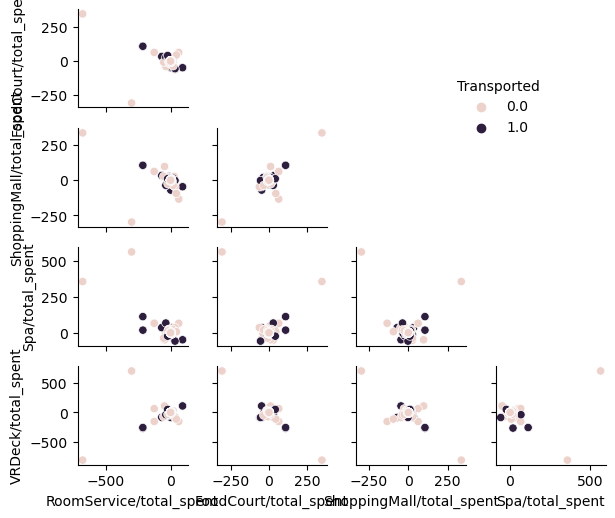

In [31]:
numerical_columns = ['RoomService/total_spent','FoodCourt/total_spent','ShoppingMall/total_spent','Spa/total_spent','VRDeck/total_spent']

figsize = (1.5, 1.3)
g = sns.PairGrid(df_concat, hue='Transported', vars=numerical_columns, height=figsize[1], aspect=figsize[0]/figsize[1])
g.map_lower(sns.scatterplot)
legend = g.add_legend(loc='upper right', bbox_to_anchor=(0.65, 0.7))

for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

plt.show()

In [77]:
original_feat = []
new_feat = []
original_feat = X_train.columns[:-10]
original_feat = X_train[original_feat]
new_feat = X_train.columns[-10:]
new_feat = X_train[new_feat]

new_feat

,RoomService/total_spent,FoodCourt/total_spent,ShoppingMall/total_spent,Spa/total_spent,VRDeck/total_spent,1/RoomService,1/FoodCourt,1/ShoppingMall,1/Spa,1/VRDeck
2207,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
4941,2.218558,1.590933,-0.935375,1.829583,2.034990,0.618892,0.863045,-1.467912,0.750470,0.674720
8557,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
8030,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
4709,1.624922,0.970582,-0.664604,1.319052,1.652520,0.600386,1.005150,-1.467912,0.739607,0.590360
...,...,...,...,...,...,...,...,...,...,...
7673,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
6167,-0.399283,0.969777,-0.394392,0.981428,0.314664,-1.449928,0.596975,-1.467912,0.589887,1.839842
3727,0.624005,0.638931,0.616361,0.656534,0.632383,-1.449928,-1.416057,-1.467912,-1.378089,-1.430721
1856,1.798703,0.600025,-0.740638,-0.788912,-0.759890,0.604430,1.811910,-1.467912,-1.378089,-1.430721


Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'total_spent', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'HomePlanet_None', 'Destination_55 Cancri e',
       'Destination_None', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'cabin_deck_A', 'cabin_deck_B',
       'cabin_deck_C', 'cabin_deck_D', 'cabin_deck_E', 'cabin_deck_F',
       'cabin_deck_G', 'cabin_deck_None', 'cabin_deck_T', 'cabin_side_None',
       'cabin_side_P', 'cabin_side_S', 'CryoSleep', 'VIP', 'Cluster'],
      dtype='object')